In [5]:
## This code was inspired from the orginal Pix2Pix implementation by tensorflow (https://www.tensorflow.org/tutorials/generative/pix2pix) and (https://www.kaggle.com/code/ekhtiar/resunet-a-baseline-on-tensorflow/notebook#Resunet)
!pip install visualkeras
from __future__ import absolute_import, division, print_function

from datetime import datetime
from packaging import version

import tensorflow as tf
import tensorboard
import visualkeras
from tensorflow.python import training

from tensorflow import keras
from tensorflow.keras import layers


import os
import time
from PIL import ImageFont
font = ImageFont.load_default()
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
problem = "Cantilever" #@param ["MMB", "Cantilever"]
method = 'ResUNet'

In [7]:
## Note: Please double chech the paths to the respective dataset.
print("Note: Please double chech the paths to the respective dataset !!")
drive.mount('/content/drive')
filepath = '/content/drive/MyDrive/Colab_Notebooks/Thesis_2022/'
if problem == 'MMB':
  path = '/content/drive/MyDrive/Colab_Notebooks/Thesis_2022/Dataset/topopt_1000_resized/'
  BUFFER_SIZE = 1472 # Size of the traning dataset
elif problem == 'Cantilever':
  path = '/content/drive/MyDrive/Colab_Notebooks/Thesis_2022/Dataset/Canti_resized/'
  BUFFER_SIZE = 836 # Size of the traning dataset
else:
  path = input("Enter path to traning and validation data: ")
print('Path: ', path)
train_path = path  + 'train/'
test_path = path + 'val/'
movie_path = path + 'topopt_1000_resized/moving_load/'
save_model = '/content/drive/MyDrive/Colab_Notebooks/Thesis_2022/TopOptPix2Pix/Models/'

%cd '/content/drive/MyDrive/Colab_Notebooks/Thesis_2022/TopOptPix2Pix'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Path:  /content/drive/MyDrive/Colab_Notebooks/Thesis_2022/Dataset/Canti_resized/
/content/drive/MyDrive/Colab_Notebooks/Thesis_2022/TopOptPix2Pix


In [8]:
EPOCHS = int(input("Enter the number of Epochs: "))
BATCH_SIZE = int(input("Enter the Batch Size: ")) # Batch size of 1 was recomended in the Pix2Pix paper.

IMG_WIDTH = 256 # Width of the traning image    
IMG_HEIGHT = 256 # Height of the traning image

Enter the number of Epochs: 200
Enter the Batch Size: 1


In [9]:
def plot_losses(g_loss, d_loss, epoch, dataset, base_path='results/'):
    if not os.path.exists(base_path):
      os.makedirs(base_path)
    total_loss = [g[0].numpy() + d[0].numpy() for g, d in zip(g_loss, d_loss)]
    g_loss = [g[0].numpy() for g in g_loss]
    d_loss = [d[0].numpy() for d in d_loss]
    plt.figure(figsize=(10,5))
    plt.plot(g_loss, label='gen')
    plt.plot(d_loss, label='disc')
    plt.plot(total_loss, label='total')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('training loss')
    plt.savefig(base_path + '/losses.png')
    plt.close()

    def smooth(y, box_pts):
        box = np.ones(box_pts)/box_pts
        y_smooth = np.convolve(y, box, mode='same')
        return y_smooth
    xs = [_ for _ in range(len(d_loss))]
    if len(xs) > 20:
        window=5
        f, axarr = plt.subplots(2, figsize=(8,4), sharex=True)
        axarr[0].plot(d_loss, alpha=0.4, linewidth=5)
        axarr[0].plot(xs[window:-window], smooth(d_loss, window)[window:-window], c='C0')
        axarr[0].set_title('Discriminator')
        axarr[0].set_yscale('log')
        axarr[0].set_ylabel('loss')
        axarr[1].plot(g_loss, alpha=0.4, linewidth=5)
        axarr[1].plot(xs[window:-window], smooth(g_loss, window)[window:-window], c='C1')
        axarr[1].set_title('Generator')
        axarr[1].set_xlabel('Epoch')
        axarr[1].set_ylabel('loss')
        plt.savefig(base_path + '/loss_tracking.png')
        plt.close()

In [10]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image


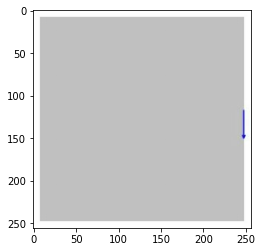

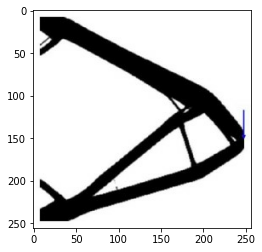

In [11]:
if problem == 'MMB':
  re, inp = load(path + 'train/6-0,497.jpg')
else:  
  re, inp = load(path + 'train/151-0,244.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.show()
plt.figure()
plt.imshow(re/255.0)
plt.show()

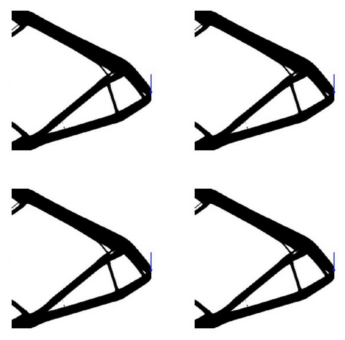

In [12]:

def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  a = input_image
  b = real_image
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return a, b

plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_re/255.0)
  plt.axis('off')
plt.show()

def load_image_train(image_file):
  real_image, input_image= load(image_file)
  real_image, input_image = random_jitter(real_image, input_image)
  real_image, input_image = normalize(real_image, input_image)

  return input_image, real_image

def load_image_test(image_file):
  real_image, input_image = load(image_file)
  real_image, input_image = resize(real_image, input_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  real_image, input_image = normalize(real_image, input_image)

  return input_image, real_image


In [13]:
"""## Input Pipeline"""

# train_dataset = tf.data.Dataset.list_files(path + 'train/*.jpg') For MMB Beams
train_dataset = tf.data.Dataset.list_files(path + 'train/*.jpg')
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.list_files(path + 'val/*.jpg')

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


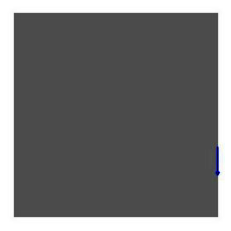

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


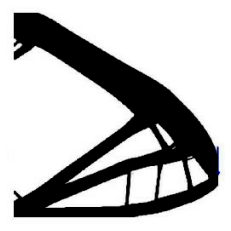

In [14]:
for a, b in train_dataset.take(1): #Take subsets the dataset into at most __1__ element (Seems to randomly create it)
  plt.figure()
  plt.imshow(tf.squeeze(a, [0]))
  plt.axis('off')
  plt.show()
  plt.figure()
  plt.imshow(tf.squeeze(b, [0]))
  plt.axis('off')
  plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


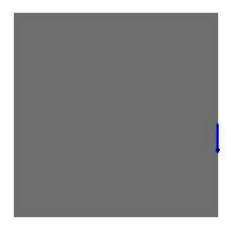

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


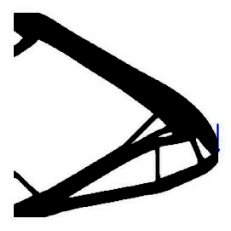

In [15]:
for a, b in test_dataset.take(1): #Take subsets the dataset into at most __1__ element (Seems to randomly create it)
  plt.figure()
  plt.imshow(tf.squeeze(a, [0]))
  plt.axis('off')
  plt.show()
  plt.figure()
  plt.imshow(tf.squeeze(b, [0]))
  plt.axis('off')
  plt.show()

In [16]:
#RGB
OUTPUT_CHANNELS = 3
# Weights initializer for the layers.
kernel_init = tf.random_normal_initializer(0, 0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Epsilon for BatchNorm
eps = 1e-05
# Momentum for BatchNorm
mom = 0.1

In [17]:

def downsample(x, filters, activation, kernel_initializer=kernel_init, kernel_size=(4, 4), strides=(2, 2), padding="same", gamma_initializer=gamma_init, use_bias=False):
    x = layers.Conv2D(filters, kernel_size, strides=strides, kernel_initializer=kernel_initializer, padding=padding, use_bias=use_bias)(x)
    x = layers.BatchNormalization(momentum=mom, epsilon=eps)(x)
    if activation:
        x = activation(x)
    return x


In [18]:
def bn_act(x, act=True): #https://www.kaggle.com/code/ekhtiar/resunet-a-baseline-on-tensorflow/notebook#Resunet                 
    'batch normalization layer with an optinal activation layer'
    x = layers.BatchNormalization()(x)
    if act == True:
        x = layers.Activation('relu')(x)
    return x

In [19]:
def conv_block(x, filters, kernel_size=3, padding='same', strides=1):
    'convolutional layer which always uses the batch normalization layer'
    conv = bn_act(x)
    conv = layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, kernel_initializer=kernel_init)(conv)
    return conv

In [20]:
def stem(x, filters, kernel_size=3, padding='same', strides=1):
    conv = layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, kernel_initializer=kernel_init)(x)
    conv = conv_block(conv, filters, kernel_size, padding, strides)
    shortcut = layers.Conv2D(filters, kernel_size=1, padding=padding, strides=strides, kernel_initializer=kernel_init)(x)
    shortcut = bn_act(shortcut, act=False)
    output = layers.Add()([conv, shortcut])
    return output

In [21]:
def residual_block(x, filters, kernel_size=3, padding='same', strides=1):
    res = conv_block(x, filters, kernel_size, padding, strides)
    res = conv_block(res, filters, kernel_size, padding, 1)
    shortcut = layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, kernel_initializer=kernel_init)(x)
    shortcut = bn_act(shortcut, act=False)
    output = layers.Add()([shortcut, res])
    return output

In [22]:
def upsample_concat_block(x, xskip):
    u = layers.UpSampling2D((2,2), interpolation='nearest')(x)
    c = layers.Concatenate()([u, xskip])
    return c

In [23]:
def build_resunet(input_shape=[256, 256, 3]):
  f = [64, 128, 256, 512, 512, 512, 512, 512]
  inputs = layers.Input(shape=input_shape, name='Gen_Input') # # (batch_size, 256, 256, 3)

  ## Encoder
  e0 = inputs
  e1 = stem(e0, f[0])
  e2 = residual_block(e1, f[1], strides=2)
  e3 = residual_block(e2, f[2], strides=2)
  e4 = residual_block(e3, f[3], strides=2) #1
  e5 = residual_block(e4, f[4], strides=2) #2
  e6 = residual_block(e5, f[5], strides=2) #3
  e7 = residual_block(e6, f[6], strides=2) #4
  e8 = residual_block(e7, f[7], strides=2) #5
  
  ## Bridge
  b0 = conv_block(e8, f[7], strides=1)
  b1 = conv_block(b0, f[7], strides=1)
  b2 = conv_block(b1, f[7], strides=1)
  
  ## Decoder
  u1 = upsample_concat_block(b2, e7)
  d1 = residual_block(u1, f[7])
  
  u2 = upsample_concat_block(d1, e6)
  d2 = residual_block(u2, f[6])

  u3 = upsample_concat_block(d2, e5)
  d3 = residual_block(u3, f[5])
  
  u4 = upsample_concat_block(d3, e4)
  d4 = residual_block(u4, f[4])
  
  u5 = upsample_concat_block(d4, e3)
  d5 = residual_block(u5, f[3])
  
  u6 = upsample_concat_block(d5, e2)
  d6 = residual_block(u6, f[2])
  
  u7 = upsample_concat_block(d6, e1)
  d7 = residual_block(u7, f[1])

  ## Last Layer
  outputs = layers.Conv2D(OUTPUT_CHANNELS, 4, strides=1, padding='same', activation='tanh', kernel_initializer=kernel_init)(d7)

  ## Model
  model = keras.models.Model(inputs, outputs, name="ResUNet")

  return model

In [ ]:
generator = build_resunet()
generator.summary()
# visualkeras.layered_view(generator, legend=True, draw_volume=False, scale_xy=2)
# tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64, show_layer_activations=True)

In [ ]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(tf.cast(gen_output[0, ...], dtype=tf.uint8))

In [ ]:
def discriminator(filters=64, kernel_initializer=kernel_init, num_downsampling=3, name='discriminator'):    
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')
    concat_input = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)
    
    x = layers.Conv2D(filters, 4, strides=(2, 2), padding="same", kernel_initializer=kernel_initializer)(concat_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(x, filters=num_filters, activation=layers.LeakyReLU(0.2), kernel_size=(4, 4), strides=(2, 2))
        else:
            x = downsample(x, filters=num_filters, activation=layers.LeakyReLU(0.2), kernel_size=(4, 4), strides=(1, 1))

    x = layers.Conv2D(1, 4, strides=(1, 1), padding="same", kernel_initializer=kernel_initializer)(x)

    model = keras.models.Model(inputs=[inp, tar], outputs=x, name=name)
    return model

In [ ]:
discriminator = discriminator()
# tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

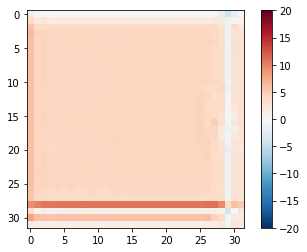

In [ ]:
dis_input = inp[tf.newaxis, ...]
disc_out = discriminator([dis_input, gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [ ]:
## Loss Function
LAMBDA = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# accuracy_object = tf.keras.metrics.categorical_accuracy()

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss
  return total_disc_loss

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
## Checkpoints

checkpoint_dir = './{}_training_checkpoints_{}_{}_{}'.format(method, problem, EPOCHS, BATCH_SIZE)
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  checkpoint.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')


Latest checkpoint restored!!


In [ ]:
def generate_images(model, test_input, tar, base_path='', epoch=0):
  if not os.path.exists(base_path):
    os.makedirs(base_path)

  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,8))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.savefig(base_path + '/result_{}.png'.format(epoch))
  plt.close()


In [ ]:

@tf.function
def train_step(input_image, target, g_loss_metric, d_loss_metric):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  g_loss_metric.update_state(gen_loss)
  d_loss_metric.update_state(disc_loss)
  # accuracy_metric.update_state(tf.ones_like(gen_output), gen_output)
  generator_gradients = gen_tape.gradient(gen_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))


In [ ]:
def train(dataset, epochs):
  g_loss_log = []
  d_loss_log = []
  g_loss_metric = tf.keras.metrics.Mean(name='g_train_loss')
  d_loss_metric = tf.keras.metrics.Mean(name='d_train_loss')
  accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
  for epoch in range(epochs):
    start = time.time()
    g_loss_metric.reset_states()
    d_loss_metric.reset_states()
    counter = 0
    for input_image, target in dataset:
      # print("Image Size : ", tf.shape(input_image))
      # print("Image Size : ", tf.shape(target))
      train_step(input_image, target, g_loss_metric, d_loss_metric)
      counter += 1
      if counter > 100:
        break
    # Get the metric results
    g_mean_loss = g_loss_metric.result()
    d_mean_loss = d_loss_metric.result()
    g_loss_log.append([g_mean_loss])
    d_loss_log.append([d_mean_loss])

    print('Epoch: ', epoch)
    print('  loss (g) (d) (g+d):     {:.3f}, {:.3f}, {:.3f}'.format(g_mean_loss, d_mean_loss, g_mean_loss + d_mean_loss))

    if (epoch) % 10 == 0:
      for i, (inp, tar) in enumerate(test_dataset.take(5)):
        generate_images(generator, inp, tar, base_path='{}_results_{}_{}_{}/{}'.format(method, problem, EPOCHS, BATCH_SIZE, i), epoch=epoch)
        plot_losses(g_loss_log, d_loss_log, epoch=epoch, dataset='dataset', base_path='{}_results_{}_{}_{}'.format(method, problem, EPOCHS, BATCH_SIZE))

    # Saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
    
      ckpt_save_path = ckpt_manager.save()
      print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))


In [ ]:
start_time = time.time()
train(train_dataset, EPOCHS)
end_time = time.time()
generator.save(filepath=save_model + '/{}/{}_Generator'.format(problem, method), save_format="tf")
print("Start Time: {} and End Time: {}".format(start_time, end_time))
print("Average Time Taken per Epoch: ", (end_time - start_time)/EPOCHS)

Epoch:  0
  loss (g) (d) (g+d):     7.867, 1.194, 9.062
Time taken for epoch 1 is 45.38152194023132 sec

Epoch:  1
  loss (g) (d) (g+d):     7.964, 1.232, 9.195
Time taken for epoch 2 is 40.54802632331848 sec

Epoch:  2
  loss (g) (d) (g+d):     7.814, 1.154, 8.968
Time taken for epoch 3 is 41.53081154823303 sec

Epoch:  3
  loss (g) (d) (g+d):     7.737, 1.243, 8.980
Time taken for epoch 4 is 41.047186851501465 sec

Epoch:  4
  loss (g) (d) (g+d):     7.961, 1.195, 9.156
Time taken for epoch 5 is 41.36398935317993 sec

Epoch:  5
  loss (g) (d) (g+d):     7.497, 1.208, 8.706
Time taken for epoch 6 is 41.13797879219055 sec

Epoch:  6
  loss (g) (d) (g+d):     7.143, 1.210, 8.353
Time taken for epoch 7 is 41.324925899505615 sec

Epoch:  7
  loss (g) (d) (g+d):     7.846, 1.132, 8.978
Time taken for epoch 8 is 41.28334021568298 sec

Epoch:  8
  loss (g) (d) (g+d):     7.598, 1.154, 8.752
Time taken for epoch 9 is 41.243311405181885 sec

Epoch:  9
  loss (g) (d) (g+d):     7.990, 1.196, 9.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab_Notebooks/Thesis_2022/TopOptPix2Pix/Models//Cantilever/ResUNet_Generator/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab_Notebooks/Thesis_2022/TopOptPix2Pix/Models//Cantilever/ResUNet_Generator/assets


Start Time: 1652171474.6321747 and End Time: 1652175665.3662863
Average Time Taken per Epoch:  41.9073411154747


In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


In [ ]:

def test_gen(model, test_inp, test_tar, savepath = 'results/final'):
  if not os.path.exists(savepath):
    os.makedirs(savepath)
  prediction = model(test_inp, training=True)
  plt.figure(figsize=(15,8))

  display_list = [test_inp[0], test_tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  for i in range(3):

    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.savefig(savepath + '/result_test.png')
  plt.close()


In [ ]:
# Testing
for inp, tar in test_dataset.take(1):
  test_gen(generator, inp, tar)

In [ ]:
  #ResUNet - Skeleton
  # e0 = inputs
  # e1 = stem(e0, f[0])
  # e2 = residual_block(e1, f[1], strides=2)
  # e3 = residual_block(e2, f[2], strides=2)
  # e4 = residual_block(e3, f[3], strides=2)
  # e5 = residual_block(e4, f[4], strides=2)
  
  # ## Bridge
  # b0 = conv_block(e5, f[4], strides=1)
  # b1 = conv_block(b0, f[4], strides=1)
  # b2 = conv_block(b1, f[4], strides=1)
  
  # ## Decoder
  # u1 = upsample_concat_block(b2, e4)
  # d1 = residual_block(u1, f[4])
  
  # u2 = upsample_concat_block(d1, e3)
  # d2 = residual_block(u2, f[3])
  
  # u3 = upsample_concat_block(d2, e2)
  # d3 = residual_block(u3, f[2])
  
  # u4 = upsample_concat_block(d3, e1)
  # d4 = residual_block(u4, f[1])